In [1]:
using CUDA, Flux
CUDA.device!(0)
Threads.nthreads()

16

In [2]:
include("utils/train.jl")

In [7]:
using BitBasis
dev = gpu

gpu (generic function with 4 methods)

In [3]:
function energy_Exact(nv, nh, Vvecs, Hvecs, rbm, J)
    enNumTot = []
    for i in 1:size(Vvecs,2) #2^nv
        rbm.v = repeat(Vvecs[:,i],1,size(Hvecs,2)) |> gpu
        rbm.h = Hvecs |> gpu
        # enNum = - (rbm.v' * (J.a |> cpu) + ((J.b' |> cpu) * rbm.h)' + diag(rbm.v' * (J.w |> cpu) * rbm.h))
        enNum = H(rbm, J)
        append!(enNumTot, enNum)
    end
    enNumTot
end

energy_Exact (generic function with 1 method)

In [8]:
samples = 50
eNumerical = zeros(1,2+samples) #[0 0 0]
eDiag = zeros(1,2+samples)
eRand = zeros(1,2+samples)

fNumerical = zeros(1,2+samples) #[0 0 0]
fDiag = zeros(1,2+samples)
fRand = zeros(1,2+samples)

sNumerical = zeros(1,2+samples) #[0 0 0]
sDiag = zeros(1,2+samples)
sRand = zeros(1,2+samples)
for nv in 1:16 
    for nh in nv:nv
        # nh=nv
        Vvecs = bitarray(collect(0:2^nv-1), nv)
        Hvecs = bitarray(collect(0:2^nh-1), nh);
    
        Vrand = randn(nv, nv)
        Hrand = randn(nh, nh);
    
        enNumL, enRBML, enRandL = [], [], []
    
        FNumL, FRBML, FRandL = [], [], []
    
        SNumL, SRBML, SRandL = [], [], []
        for s in 1:samples
            rbm, J, m, hparams, rbmZ = initModel(nv=nv, nh=nh, batch_size=10, lr=1.5, t=10, gpu_usage = true, optType="Adam")
    
            #Exact
            rbm.v = Vvecs |> gpu
            rbm.h = Hvecs |> gpu
            rbm.v = rbm.v ./ (sum(rbm.v, dims=1) .+ 1e-9)
            rbm.h = rbm.h ./ (sum(rbm.h, dims=1) .+ 1e-9)
            enNum = H(rbm, J)
            # enNum = energy_Exact(nv, nh, Vvecs, Hvecs, rbm, J)
            append!(enNumL, sum(exp.(- enNum) .* enNum)/sum(exp.(- enNum)))
            append!(FNumL, -log(sum(exp.(- enNum))) )
            # append!(SNumL, enNumL - FNumL )
    
            #Diag
            H_eff = H_effective(J, hparams; dev)
            F = LinearAlgebra.svd(H_eff, full=false);
            append!(enRBML, sum(exp.(-F.S) .* F.S)/sum(exp.(-F.S)))
            append!(FRBML, -log(sum(exp.(- F.S))) )
            # append!(SRBML, enRBML - FRBML )
            
            #Random Gaussian vectors
            rbm.v = Vrand |> gpu
            rbm.h = Hrand |> gpu
            enNum = H(rbm, J)
            # enNum = energy_Exact(nv, nh, Vrand, Hrand, rbm, J)
            append!(enRandL, sum(exp.(- enNum) .* enNum)/sum(exp.(- enNum)))
            append!(FRandL, -log(sum(exp.(- enNum))) )
            # append!(SRandL, enRandL - FRandL )
        end
    
        fNumerical = vcat(fNumerical, [nv nh FNumL']) 
        fDiag = vcat(fDiag, [nv nh FRBML'])
        fRand = vcat(fRand, [nv nh FRandL'])
    
        sNumerical = vcat(sNumerical, [nv nh (enNumL .- FNumL)']) 
        sDiag = vcat(sDiag, [nv nh (enRBML .- FRBML)'])
        sRand = vcat(sRand, [nv nh (enRandL .- FRandL)'])
    
        eNumerical = vcat(eNumerical, [nv nh enNumL']) 
        eDiag = vcat(eDiag, [nv nh enRBML'])
        eRand = vcat(eRand, [nv nh enRandL'])
    end
end
fNumerical = fNumerical[2:end, :]
fDiag = fDiag[2:end, :]
fRand = fRand[2:end, :];

sNumerical = sNumerical[2:end, :]
sDiag = sDiag[2:end, :]
sRand = sRand[2:end, :];

eNumerical = eNumerical[2:end, :]
eDiag = eDiag[2:end, :]
eRand = eRand[2:end, :];

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007f5447f12590.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/HaQcr/src/GPUArraysCore.jl:106


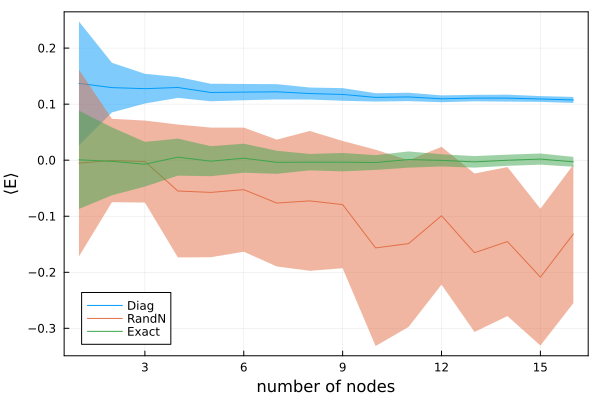

In [9]:
plot(eDiag[:,1],mean(eDiag[:,3:end], dims=2)[:], ribbon=std(eDiag[:,3:end], dims=2)[:], label="Diag")
plot!(eRand[:,1],mean(eRand[:,3:end], dims=2)[:], ribbon=std(eRand[:,3:end], dims=2)[:], label="RandN")
plot!(eNumerical[:,1],mean(eNumerical[:,3:end], dims=2)[:], ribbon=std(eNumerical[:,3:end], dims=2)[:], label="Exact")
plot!(xlabel="number of nodes", ylabel="⟨E⟩", frame=:box, legend=:bottomleft)

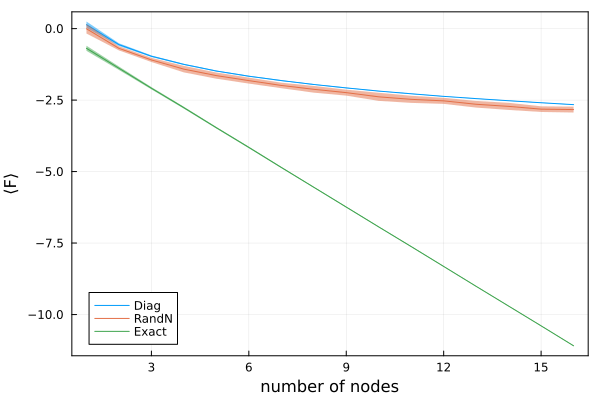

In [10]:
plot(fDiag[:,1],mean(fDiag[:,3:end], dims=2)[:], ribbon=std(fDiag[:,3:end], dims=2)[:], label="Diag")
plot!(fRand[:,1],mean(fRand[:,3:end], dims=2)[:], ribbon=std(fRand[:,3:end], dims=2)[:], label="RandN")
plot!(fNumerical[:,1],mean(fNumerical[:,3:end], dims=2)[:], ribbon=std(fNumerical[:,3:end], dims=2)[:], label="Exact")
plot!(xlabel="number of nodes", ylabel="⟨F⟩", frame=:box, legend=:bottomleft)

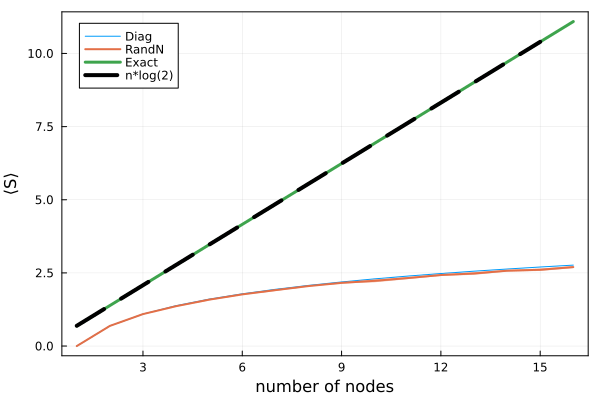

In [11]:
plot(sDiag[:,1],mean(sDiag[:,3:end], dims=2)[:], ribbon=std(sDiag[:,3:end], dims=2)[:], label="Diag")
plot!(sRand[:,1],mean(sRand[:,3:end], dims=2)[:], ribbon=std(sRand[:,3:end], dims=2)[:], label="RandN", lw=2)
plot!(sNumerical[:,1],mean(sNumerical[:,3:end], dims=2)[:], ribbon=std(sNumerical[:,3:end], dims=2)[:], label="Exact", lw=3)
plot!(1:15,collect(1:15) .* log(2), label="n*log(2)", ls=:dash, lw=4, c=:black)
plot!(xlabel="number of nodes", ylabel="⟨S⟩", frame=:box, legend=:topleft)

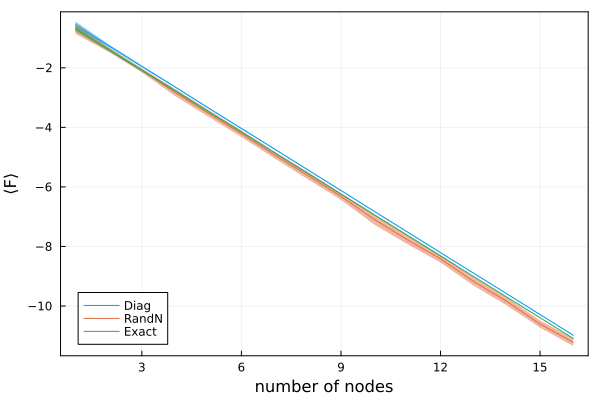

In [12]:
plot(fDiag[:,1],mean(eDiag[:,3:end], dims=2)[:] .- collect(1:16) .* log(2), ribbon=std(eDiag[:,3:end], dims=2)[:], label="Diag")
plot!(fRand[:,1],mean(eRand[:,3:end], dims=2)[:] .- collect(1:16) .* log(2), ribbon=std(eRand[:,3:end], dims=2)[:], label="RandN")
plot!(fNumerical[:,1],mean(fNumerical[:,3:end], dims=2)[:], ribbon=std(fNumerical[:,3:end], dims=2)[:], label="Exact")
plot!(xlabel="number of nodes", ylabel="⟨F⟩", frame=:box, legend=:bottomleft)